<a href="https://colab.research.google.com/github/AnDDoanf/phoBERT_projects/blob/master/phoBERT%26CNN_Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
# !kaggle datasets download -d duchuy3008/datacomments
# !unzip *.zip -d data-comments
# !rm *.zip

In [ ]:
!pip install optuna

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup, AdamW
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, optuna, re, string
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from sklearn.model_selection import train_test_split
from collections import Counter
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from string import ascii_lowercase
import warnings
warnings.filterwarnings('ignore')

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def clean(data):
    data = data.lower()
    with open('data-comments/teencode4.txt','r') as file:
        file = file.read()
        lines = file.split('\n')
        for line in lines:
            elements = line.split('\t')
            data = re.sub(r'\b{}+\b'.format(elements[0]), elements[1], data)
    alphabet = 'abcdefghijlmnopqrstuvwxyz'

    for c in alphabet:
        data = re.sub(r'{}+'.format(c), c, data)
    data = re.sub(r'\s+', ' ', data)

    return data

In [ ]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        num_classes = num_classes  # number of targets to predict
        output_channel = 36 # number of kernels
        dropout = 0.4  # dropout value
        embedding_dim = 768  # length of embedding dim

        ks = 3  # three conv nets here

        input_channel = 4

        # 3 convolutional nets
        self.conv1 = nn.Conv2d(input_channel,
                               output_channel,
                               (3, embedding_dim),
                               padding=(2, 0),
                               groups=input_channel)

        self.conv2 = nn.Conv2d(input_channel,
                               output_channel,
                                (4, embedding_dim),
                               padding=(3, 0),
                               groups=input_channel)

        self.conv3 = nn.Conv2d(input_channel,
                               output_channel,
                                (5, embedding_dim),
                               padding=(4, 0),
                               groups=input_channel)
        #stride=(1, 1),
        # apply dropout
        self.dropout = nn.Dropout(dropout)

        # fully connected layer for classification
        # 3x conv nets * output channel
        self.fc1 = nn.Linear(ks * output_channel, num_classes)

    def forward(self, x, **kwargs):
        # squeeze to get size; (batch, channel_output, ~=sent_len) * ks
        x = [F.relu(self.conv1(x)).squeeze(3),
             F.relu(self.conv2(x)).squeeze(3),
             F.relu(self.conv3(x)).squeeze(3)]
        # max-over-time pooling; # (batch, channel_output) * ks
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        # concat results; (batch, channel_output * ks)
        x = torch.cat(x, 1)
        # add dropout
        x = self.dropout(x)
        # generate logits (batch, target_size)
        logit = self.fc1(x)
        return logit

In [ ]:
df_train = pd.read_excel('data-comments/train.xlsx')
df_test =  pd.read_excel('data-comments/test.xlsx')
df_valid = pd.read_excel('data-comments/valid.xlsx')

train_texts = df_train['Sentence'].apply(clean)
test_texts = df_test['Sentence'].apply(clean)
valid_texts = df_valid['Sentence'].apply(clean)

y= LabelEncoder()

train_labels = y.fit_transform(df_train['Emotion'])
valid_labels = y.fit_transform(df_valid['Emotion'])
test_labels = y.fit_transform(df_test['Emotion'])

model_name = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True).cuda()

max_length = 256
train_encodings = tokenizer(list(train_texts),
                            truncation=True,
                            padding=True,
                            max_length=max_length,
                            return_tensors='pt' )

valid_encodings = tokenizer(list(valid_texts),
                            truncation=True,
                            padding=True,
                            max_length=max_length,
                            return_tensors='pt')

test_encodings = tokenizer(list(test_texts),
                           truncation=True,
                           padding=True,
                           max_length=max_length,
                           return_tensors='pt')

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)
test_dataset = NewsGroupsDataset(test_encodings, test_labels)

train_dataloader = DataLoader(train_dataset,
                              batch_size=8,
                              shuffle=False)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=8,
                              shuffle=False)

test_dataloader = DataLoader(test_dataset,
                              batch_size=8,
                              shuffle=False)

In [ ]:
# instantiate CNN
CNN_model = CNN(num_classes=7).cuda()

# set loss
criterion = nn.CrossEntropyLoss()

# set number of epochs
epochs = 5

# optimizer = AdamW(model.parameters(), lr=5e-5)  #weight_decay
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
# optimizer = AdamW([{'params': BERT_parameters, 'lr': 2e-5}], weight_decay=1.0)

# set LR scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# create gradient scaler for mixed precision
scaler = GradScaler()

In [ ]:
def train(model, dataloader, optimizer):
    # reset total loss for epoch
    train_total_loss = 0

    # put both models into traning mode
    model.train()
    CNN_model.train()

    # for each batch of training data...
    for step, batch in enumerate(dataloader):
        b_input_ids = batch['input_ids'].cuda()
        b_input_mask = batch['attention_mask'].cuda()
        b_labels = batch['labels'].cuda().long()
        # clear previously calculated gradients
        optimizer.zero_grad()

        # runs the forward pass with autocasting.
        with autocast():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            hidden_layers = outputs['hidden_states']  # get hidden layers

            hidden_layers = torch.stack(hidden_layers, dim=1)  # stack the layers

            hidden_layers = hidden_layers[:, -4 :]
            # hidden_layers = hidden_layers[:, :]

        logits = CNN_model(hidden_layers)
        loss = criterion(logits, b_labels.view(-1))

        # sum the training loss over all batches for average loss at end
        # loss is a tensor containing a single value
        train_total_loss += loss.item()

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        # Update the scheduler
        scheduler.step()

        # calculate preds
        _, predicted = torch.max(logits, 1)

        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy().ravel()

        # calculate f1


    # calculate the average loss over all of the batches
    avg_train_loss = train_total_loss / len(dataloader)


    # Record all statistics from this epoch.
    training_stats.append({
            'Train Loss': avg_train_loss,
    })
    #torch.cuda.empty_cache()

    return None

def validating(model, dataloader):
    # put both models in evaluation mode
    model.eval()
    CNN_model.eval()

    total_valid_loss = 0
    total_accuracy=0
    # evaluate data for one epoch
    for batch in dataloader:

        b_input_ids = batch['input_ids'].cuda()
        b_input_mask = batch['attention_mask'].cuda()
        b_labels = batch['labels'].cuda().long()

        # tell pytorch not to bother calculating gradients
        with torch.no_grad():
            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

            hidden_layers = outputs['hidden_states']  # get hidden layers

            hidden_layers = torch.stack(hidden_layers, dim=1)  # stack the layers
#             hidden_layers = hidden_layers[:, :]
            hidden_layers = hidden_layers[:, -4 :]

        logits = CNN_model(hidden_layers)
        loss = criterion(logits, b_labels.view(-1))

        _, predicted = torch.max(logits, 1)
      # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy().ravel()

        # accumulate validation loss
        total_valid_loss += loss.item()
        total_accuracy += accuracy_score(predicted, y_true)

    avg_val_loss = total_valid_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    # Record all statistics from this epoch.
    valid_stats.append({
      'Val Loss': avg_val_loss,
      'Accuracy': avg_accuracy,
    })
    return None


def testing(model, CNN_model, dataloader):
    # put both models in evaluation mode
    y_pred = []

    # evaluate data for one epoch
    for batch in dataloader:

        b_input_ids = batch['input_ids'].cuda()
        b_input_mask = batch['attention_mask'].cuda()
        b_labels = batch['labels'].cuda().long()

        # tell pytorch not to bother calculating gradients
        with torch.no_grad():
            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            hidden_layers = outputs['hidden_states']  # get hidden layers

            hidden_layers = torch.stack(hidden_layers, dim=1)  # stack the layers

#             hidden_layers = hidden_layers[:,:]
            hidden_layers = hidden_layers[:, -4 :]

        logits = CNN_model(hidden_layers)

        # accumulate validation loss
#         total_test_loss += loss.item()

        # calculate preds
        _, predicted = torch.max(logits, 1)

        # move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        y_true = b_labels.detach().cpu().numpy().ravel()

        for i in predicted:
            y_pred.append(i)

    return y_pred

In [ ]:
training_stats = []
valid_stats = []
best_valid_loss = float('inf')
best_valid_acc = 0
timeline = []

# for each epoch
print('Training...')
print("epoch | train loss | val loss | accuracy")
for epoch in range(epochs):
    time_start = time.time()
    # train
    train(model, train_dataloader, optimizer)
    # validate
    validating(model, valid_dataloader)
    print(f"{epoch+1:5d}/{epochs} | {training_stats[epoch]['Train Loss']:<10.5f} | {valid_stats[epoch]['Val Loss']:<8.5f} | {valid_stats[epoch]['Accuracy']:<5.3f}")
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']
        torch.save(CNN_model.state_dict(), 'data-comments/checkpoint_save/val-cnn-model.pt')  # torch save
        torch.save(model.state_dict(), 'data-comments/checkpoint_save/val-bert-cnn-model.pt')
        model.save_pretrained('data-comments/model_save/val-acc-bert-cnn/')
    time_end = time.time()
    timeline.append(time_end - time_start)

Training...
epoch | train loss | val loss | accuracy
    1/5 | 1.73459    | 1.43753  | 0.495
    2/5 | 1.28453    | 1.26274  | 0.568
    3/5 | 0.93976    | 1.23085  | 0.579
    4/5 | 0.65737    | 1.24169  | 0.592
    5/5 | 0.48575    | 1.29056  | 0.579


In [ ]:
model.load_state_dict(torch.load('data-comments/checkpoint_save/val-bert-cnn-model.pt'))
CNN_model.load_state_dict(torch.load('data-comments/checkpoint_save/val-cnn-model.pt'))
y_pred = testing(model, CNN_model,test_dataloader)
print(classification_report(test_dataset[:]['labels'].ravel(),y_pred,digits=3)) #3 # 0.558

              precision    recall  f1-score   support

           0      0.415     0.550     0.473        40
           1      0.593     0.409     0.484       132
           2      0.656     0.751     0.700       193
           3      0.696     0.696     0.696        46
           4      0.567     0.457     0.506       129
           5      0.602     0.690     0.643       116
           6      0.467     0.568     0.512        37

    accuracy                          0.596       693
   macro avg      0.571     0.589     0.574       693
weighted avg      0.597     0.596     0.590       693



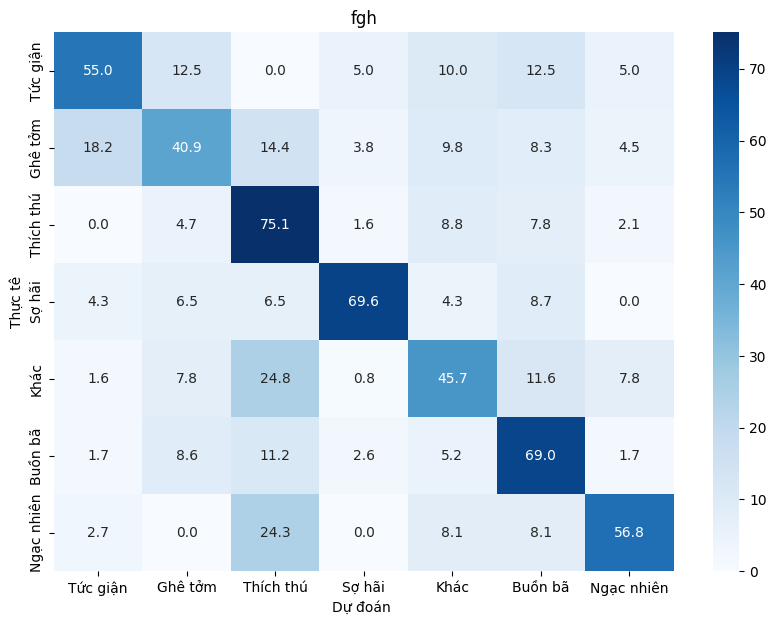

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
confuse = confusion_matrix(test_labels, y_pred)

fig = plt.figure(figsize=(10, 7))
id2label = {0: "Anger", 1: "Disgust", 2: "Enjoyment", 3: "Fear", 4: "Other", 5: "Sadness", 6: "Surprise"}



ax = sns.heatmap( np.round(np.divide(confuse, np.sum(confuse, axis=1).reshape(-1, 1)) * 100, 1), fmt="", annot=True, cmap='Blues')
ax.set_title('fgh')
ax.set_xlabel('Dự đoán ')
ax.set_ylabel('Thực tê');

ax.xaxis.set_ticklabels(["Tức giận",  "Ghê tởm", "Thích thú", "Sợ hãi", "Khác", "Buồn bã", "Ngạc nhiên"])
ax.yaxis.set_ticklabels(["Tức giận",  "Ghê tởm", "Thích thú", "Sợ hãi", "Khác", "Buồn bã", "Ngạc nhiên"])

plt.show()